# Notes

If you want to run the notebook presented below, please follow the below guidelines:

- Download the imdb dataset 25m provided by Grouplens from https://grouplens.org/datasets/movielens/25m/ and extract it on the **data** folder.

- Make sure that you have all the availble tools and packages installed provided by the python scientific software stack. At a minimum you need: Numpy, Pandas, Matplotlib and Jupyter. I am currently using **Anaconda** manager which has all the available packages.

# IMDB Movie Dataset - Genre Analysis - Week 6 Mini-project
**Konstantinos Kostis**

## Dataset: https://grouplens.org/datasets/movielens/25m/

## Motivation

What i would like to investigate is which movie genres people prefer most, for a specific year. For example, this could be really helpful for movie production companies to prioritize what kind of movies they should make in order to increase their sales for the next year. So by definition this investigation should be a comparative analysis of movie genres.

## Research Question

So a well-defined research question is the following:

1. **According to users ratings of 2012, can we find the genres order of preference for the movies produced in 2012?**
  - What happens if the mean of ratings is used?
  - What happens if the median of ratings is used?
  
*Note that the year 2012 is a significant one, at least scientifically speaking. It was the year that CERN confirmed the existence of Higgs Boson and the year that ‘Curiosity’ landed on Mars!*

## Load the needed libraries

In [1]:
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

## Reading the data

In [2]:
# read the movies dataset
movies = pd.read_csv('data/movies.csv')

movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
# read  the ratings dataset
ratings = pd.read_csv('data/ratings.csv')

ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


## Preparing the data

This step involves data manipulation of the movies and ratings dataframes in order to create the needed dataframes
for plotting reasons.

In [4]:
# manipulating ratings

# create a new column for the year the rating was given
ratings['rating_year'] = pd.to_datetime(ratings['timestamp'], unit='s').dt.to_period('Y')

# select only the ratings which are given in the year of interest: 2012
year_of_interest = '2012'
stage_ratings = pd.DataFrame(ratings[ratings['rating_year'] == year_of_interest])

# drop the un-needed columns
del stage_ratings['timestamp']
del stage_ratings['rating_year']
del stage_ratings['userId']

stage_ratings.head()

,movieId,rating
4495,69,3.0
4496,73,3.5
4497,88,3.5
4498,147,3.5
4499,175,3.0


In [5]:
# manipulating movies

# extract from title, the year each movie was created
movies['year'] = movies['title'].str.extract('\((.*)\)')

# select only the movies for the year of interest and make it a new dataframe
stage_movies = pd.DataFrame(movies[movies['year'] == year_of_interest])

# split genres strings to arrays
stage_movies['genres'] = stage_movies['genres'].str.split('|').to_list()

# find the unique genres
genre_lists = stage_movies['genres'].values
unique_genres = set([genre
                 for genre_list in genre_lists
                  for genre in genre_list])


print("Unique genres: {}".format(unique_genres))

Unique genres: {'Film-Noir', 'Drama', 'Animation', 'Mystery', 'Romance', 'Children', 'Fantasy', 'War', 'IMAX', 'Action', 'Horror', 'Crime', 'Musical', 'Sci-Fi', 'Comedy', '(no genres listed)', 'Thriller', 'Western', 'Adventure', 'Documentary'}


In [6]:
# continue manipulating movies

# task: expand genres to separate columns with True/False values

# 1. first create the new column names
genre_columns = ["Genre_{}".format(genre) for genre in unique_genres]

# 2. then add every new column to the dataframe and initialize all values to False
for genre_column in genre_columns:
    stage_movies[genre_column] = False

# 3. then according to the genres for every movie set the value of the respective column to True
for idx, row in stage_movies.iterrows():
    for genre in unique_genres:
        if genre in row['genres']:
            genre_column = "Genre_{}".format(genre)
            stage_movies.loc[idx, genre_column] = True

# drop rows (movies) which do not have genres listed
no_genres_mask = stage_movies['Genre_(no genres listed)'] == True
stage_movies.drop(stage_movies[no_genres_mask].index, inplace=True)

# drop the un-needed genres column
del stage_movies['genres']

In [7]:
# merge the stage_movies dataframe and stage_ratings dataframe using inner join on the movieId column
stage_merged = stage_movies.merge(stage_ratings, on='movieId', how='inner')

# drop every genre column from the merged dataframe if it contains only False values
for genre_column in genre_columns:
    all_false = (stage_merged[genre_column] == False).all()
    if all_false:
        del stage_merged[genre_column]

In [8]:
# select the columns that start with 'Genre' from the stage_merged dataframe
genre_df_columns = [column_name for column_name in stage_merged.columns if 'Genre' in column_name]

genre_ratings_data = []

# iterate all genres and compute their mean and median rating, and create a list of dictionaries
for genre_column in genre_df_columns:
    mean_computed_df = stage_merged[[genre_column, 'rating']].groupby(genre_column, as_index=False).mean()
    mean_rating = mean_computed_df[mean_computed_df[genre_column] == True]['rating'].values[0]

    median_computed_df = stage_merged[[genre_column, 'rating']].groupby(genre_column, as_index=False).median()
    median_rating = median_computed_df[median_computed_df[genre_column] == True]['rating'].values[0]
    
    prefix, genre = genre_column.split('_')
    
    record = {'Genre': genre, 'Mean_Rating': mean_rating, 'Median_Rating': median_rating}
    genre_ratings_data.append(record)
    
# create a new dataframe to contain the per genre needed data
genres_df = pd.DataFrame(genre_ratings_data)
genres_df.head(len(genre_df_columns))

,Genre,Mean_Rating,Median_Rating
0,Drama,3.578400,3.50
1,Animation,3.536410,3.50
2,Mystery,3.323370,3.50
3,Romance,3.623829,4.00
4,Children,3.558464,3.50
5,Fantasy,3.292042,3.50
6,War,3.560554,3.50
7,IMAX,3.725516,4.00
8,Action,3.622596,3.50
9,Horror,3.374686,3.50


In [9]:
# create the final dataframes for visualization
genres_by_mean_rating = pd.DataFrame(genres_df[['Genre', 'Mean_Rating']]).sort_values(by='Mean_Rating', ascending=False)
genres_by_median_rating = pd.DataFrame(genres_df[['Genre', 'Median_Rating']]).sort_values(by='Median_Rating', ascending=False)

In [10]:
# genres_by_mean_rating values
genres_by_mean_rating.head(20)

,Genre,Mean_Rating
15,Western,4.152174
16,Adventure,3.752180
7,IMAX,3.725516
10,Crime,3.720571
12,Sci-Fi,3.694960
3,Romance,3.623829
8,Action,3.622596
17,Documentary,3.581140
0,Drama,3.578400
6,War,3.560554


In [11]:
# genres_by_median_rating values
genres_by_median_rating.head(20)

,Genre,Median_Rating
15,Western,4.25
10,Crime,4.00
16,Adventure,4.00
3,Romance,4.00
7,IMAX,4.00
12,Sci-Fi,4.00
0,Drama,3.50
14,Thriller,3.50
13,Comedy,3.50
11,Musical,3.50


## Findings and visualizations

### Part one: Genres movie preference by mean rating

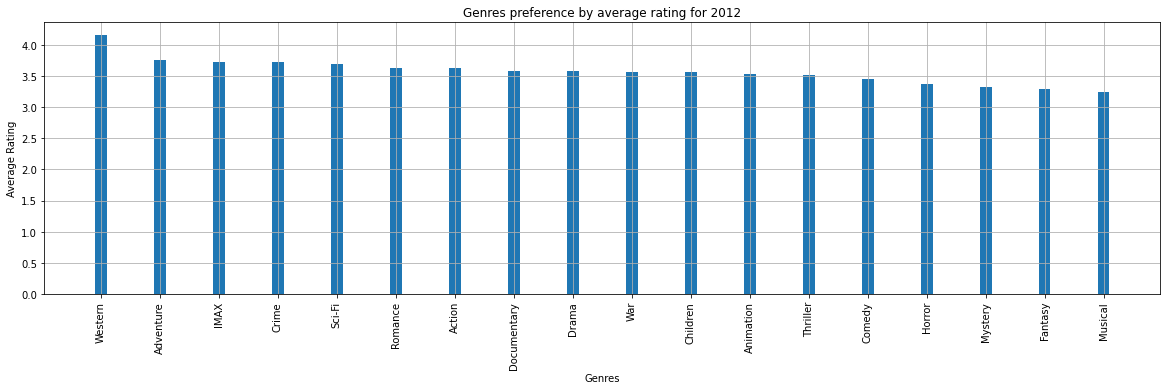

In [12]:
# visualize the genres_by_mean_rating data
plt.figure(figsize=(20, 5))
plt.grid(True)

plt.bar(genres_by_mean_rating['Genre'], genres_by_mean_rating['Mean_Rating'], width=0.2)

plt.title('Genres preference by average rating for 2012')
plt.xlabel('Genres')
plt.ylabel('Average Rating')

plt.xticks(rotation=90)

plt.show()

### Part two: Genres movie preference by median rating

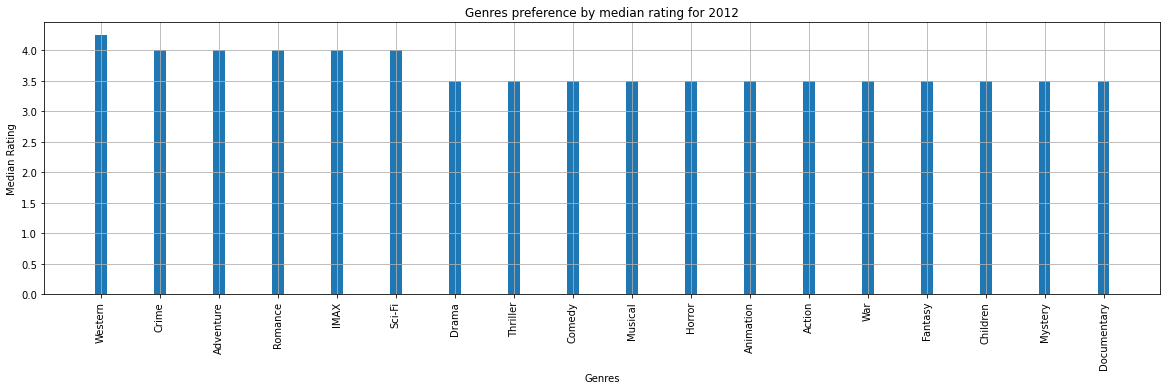

In [13]:
# visualize the genres_by_median_rating data
plt.figure(figsize=(20, 5))
plt.grid(True)

plt.bar(genres_by_median_rating['Genre'], genres_by_median_rating['Median_Rating'], width=0.2)

plt.title('Genres preference by median rating for 2012')
plt.xlabel('Genres')
plt.ylabel('Median Rating')

plt.xticks(rotation=90)

plt.show()

### Collected findings

So the summary of findings can be depicted in the following list:

1. According to 2012 users mean ratings by genre for movies produced in 2012 the order of preference regarding to genres is: ['Western','Adventure','IMAX','Crime','Sci-Fi','Romance','Action','Documentary','Drama','War',
'Children','Animation','Thriller','Comedy','Horror','Mystery','Fantasy','Musical']

2. According to 2012 users median ratings by genre for movies produced in 2012 the order of preference regarding to genres is: ['Western','Crime','Adventure','Romance','IMAX','Sci-Fi','Drama','Thriller','Comedy','Musical',
'Horror','Animation','Action','War','Fantasy','Children','Mystery','Documentary']

3. The results for mean and median differ! Just Look at the above lists to verify the position of genres for each case.

4. The '(no genres listed)' and 'Film-Noir' are dismissed as no movies with these genres remain through the end of the analysis.

5. Mean rating provides better results, since the median rating contains a lot of duplicate values and the column is sensitive to ordering meaning that everytime the analysis is run a different ordering might appear regarding the median rating.